# Studying US Elections with Linear Regressions: Votes and its Demography at County Level
---

[Psephology](https://en.wikipedia.org/wiki/Psephology) is the term used in political science that defines the quantitative analysis of elections and balloting. As you have recently seen around any major political event or election, the news papers and specialised websites fill up with graphs and statistical models trying to explain those outcomes. This activity, very much related to data science, has received the name of [data journalism](https://en.wikipedia.org/wiki/Data_journalism). Forecasting result of elections has also become a very popular activity, since is the moment where the models created over years of study are really tested. 2016 was particularly a [tragical year for pollsters](https://www.bbc.com/news/uk-politics-38402133) since they failed to predict the outcomes of major political events such as the [Brexit Referendum](https://en.wikipedia.org/wiki/2016_United_Kingdom_European_Union_membership_referendum) and the [2016 US Presidential Election](https://en.wikipedia.org/wiki/2016_United_States_presidential_election). The truth is that the models were [as good as always](https://fivethirtyeight.com/features/the-polls-are-all-right/). However, forecasting is a complex activity and the models are not fail-proof; a small bias in one direction can affect the prediction substantially. But most importantly, a prediction comes usually with a measure of uncertainty, so that in a close race where the margin is very small, the prediction can be very unreliable. Then, how do the people studying elections build these models? The methodologies used in the most famous ones consist in an elaborated combination of pre-election pollsters data and something called “fundamentals”. These fundamentals are relevant datasets such as whether a candidate is incumbent, their approval rates among the population, economic indicators and results in previous elections. For more information, see how the models from [FiveThirtyEight](https://fivethirtyeight.com/features/how-fivethirtyeights-2020-presidential-forecast-works-and-whats-different-because-of-covid-19/) and [The Economist](https://projects.economist.com/us-2020-forecast/president/how-this-works) are built (by the way, the
last one is [implemented in R](https://github.com/TheEconomist/us-potus-model)).

In this session we are going to study some of this fundamentals. Particularly, we will see how demographic indicators are related to party votes. The best way to do this is by surveying a representative sample people, so that you can have your data disaggregated at the individual level. However, such kind of surveys are usually costly and you really need a significant number of respondents. An alternative and cheaper way to understand how these demographics are related to party vote is to look at the results of an election at the highest resolution possible (county level in our case) and assume that differences on counties demographics explain differences in counties vote.   

So, turn on your computer (instead of your voice recorder), open up your RStudio (instead of your notebook), and let's play the data journalist for a while! 

## Exploring and Cleaning the Dataset
---

The results of the US elections at county level is public access and can be downloaded from official repositories. A similar thing happens for demographic data. Usually, finding all these datasets, aggregating them to one single file and cleaning the dataset is a tedious task the most of the times a data scientist must do. Fortunately, the [MIT election lab](https://electionlab.mit.edu/), a lab based in the MIT (Boston) that promotes the scientific research and study of the democracy in the US, contains a repository of datasets already structured and ready to use. In particular we will use [this](https://github.com/MEDSL/2018-elections-unoffical/raw/master/election-context-2018.csv) dataset with 2016 US Presidential Election Results at county level that also includes some demographic indicators.

First thing is download this CSV and save it into your folder for this lab. Then, once in RStudio we set that folder as our working directory and read the CSV file using the function `read.csv()`.

In [1]:
# Set my working directory
setwd("/home/mario/Dropbox/Teaching/Essex/2020-2021/MA334_Data_Analysis_and_Statistics_in_R/Labs/LinearRegression")

#Import CSV
rawdf <- read.csv("election-context-2018.csv")

Let's see the structure of this dataset by using `str()`.

In [2]:
str(rawdf)

'data.frame':	3114 obs. of  39 variables:
 $ state                 : Factor w/ 50 levels "Alabama","Arizona",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ county                : Factor w/ 1810 levels "Abbeville","Acadia",..: 79 86 97 145 160 218 228 239 286 308 ...
 $ fips                  : int  1001 1003 1005 1007 1009 1011 1013 1015 1017 1019 ...
 $ trump16               : int  18172 72883 5454 6738 22859 1140 4901 32865 7843 8953 ...
 $ clinton16             : int  5936 18458 4871 1874 2156 3530 3726 13242 5784 1547 ...
 $ otherpres16           : int  865 3874 144 207 573 40 105 1757 273 233 ...
 $ romney12              : int  17379 66016 5550 6132 20757 1251 5087 30278 7626 7506 ...
 $ obama12               : int  6363 18424 5912 2202 2970 4061 4374 15511 6871 2132 ...
 $ otherpres12           : int  190 898 47 86 279 10 35 468 114 141 ...
 $ demsen16              : int  6331 19145 4777 2082 2980 3364 3663 14152 5845 1915 ...
 $ repsen16              : int  18220 74021 5436 6612 22169 1167 4840

As you can see, the first three columns contain the state, county and county code respectively. Then, we have a set of columns that contain the votes for each party/candidate in different elections (President, Senate and House of Representatives) and for different years. Then we have a column for the estimate population and the estimate of citizen voting-age population in that county. Finally we have 16 columns with demographic indicators (check the [description here](https://github.com/MEDSL/2018-elections-unoffical/blob/master/election-context-2018.md)).

Let's keep the column names of the demographics in a vector, since we are going to use them later on. We will leave the `ruralurban_cc` (rural-urban continuum codes) out.

In [3]:
demographics <- names(rawdf)[24:38]

Now let's create two extra columns with the percentage vote for Democrats and Republicans. Since we are going to consider the vote for each party over the cast vote, we need to divide by the sum of all vote columns (`trump16 + clinton16 + otherpres16`) rather than the `total_population` or the `cvap`.

In [4]:
rawdf$dem16_pct <- rawdf$clinton16 / (rawdf$trump16 + rawdf$clinton16 + rawdf$otherpres16) * 100
rawdf$rep16_pct <- rawdf$trump16 / (rawdf$trump16 + rawdf$clinton16 + rawdf$otherpres16) * 100

Our analysis will be constrained to these two columns plus the demographics, so we can create a new clean data frame `df` with the columns of interest using the `select()` function. This is part of the `dplyr` library, so we will need to import the library first, then select the columns we want to keep.

In [5]:
library(dplyr)

# Define the columns wanted in a vector
cols_to_keep <- c(c("state","county","fips","dem16_pct","rep16_pct"),demographics)

# Select only the columns wanted
df <- select(rawdf, cols_to_keep)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Checking the summary statistics is always a good idea to spot odd values or inconsistencies.

In [6]:
# Summary Statistics
summary(df)

      state             county          fips         dem16_pct    
 Texas   : 254   Washington:  31   Min.   : 1001   Min.   : 0.00  
 Georgia : 159   Franklin  :  26   1st Qu.:19040   1st Qu.:20.36  
 Virginia: 134   Jefferson :  26   Median :29210   Median :28.30  
 Kentucky: 120   Jackson   :  24   Mean   :30660   Mean   :31.55  
 Missouri: 116   Lincoln   :  24   3rd Qu.:46006   3rd Qu.:39.91  
 Kansas  : 105   Madison   :  20   Max.   :56045   Max.   :90.86  
 (Other) :2226   (Other)   :2963                   NA's   :1      
   rep16_pct        white_pct          black_pct        hispanic_pct   
 Min.   : 4.087   Min.   :  0.7602   Min.   : 0.0000   Min.   : 0.000  
 1st Qu.:54.420   1st Qu.: 65.5814   1st Qu.: 0.5873   1st Qu.: 1.939  
 Median :66.336   Median : 84.7124   Median : 2.1211   Median : 3.832  
 Mean   :63.224   Mean   : 77.3630   Mean   : 8.9630   Mean   : 8.989  
 3rd Qu.:74.902   3rd Qu.: 93.2647   3rd Qu.:10.1680   3rd Qu.: 9.165  
 Max.   :96.033   Max.   :100.00

There are already interesting insights we can grasp from this information. For example, in the distribution of the `dem16_pct` votes shows very low values, whereas the `rep16_pct` shows rather high. This seems to contradict the fact the Democrats won the election in terms of national vote. However, bear in mind that this dataset refers to counties (one county one row/point) and we know Republicans have the vote much more dispersed than Democrats. Republicans win in most of the counties but less populated, whereas Democrats win in few of them but much more populated.

We should also note that all columns present some NA's. We can get rid of all rows with NA's with the `na.omit()`, so the corresponding counties will not count in our analysis. This will give us a final clean dataset before starting any analysis.

In [7]:
# Remove rows with NA's
df <- na.omit(df)

## Correlation
---

Before starting any linear regression we need first to check a couple of things. A linear regression is a way to fit the parameters for a linear model. When we only have one variable in our model (univariate) we talk about the "simple linear regression", which is what we will study in here with US election vote and demographics data. The term __linear__ is probably the important one in this section. Performing a linear regression is using a model that assumes the relationship between the variables is linear. If we do not have any evidence that such type of relationship takes place we simply should not use such kind of models models. For example, if we try to model the world's population growth with a linear regression or [other possible missues](https://www.youtube.com/watch?v=9saL47Nuguw). If we insist and do use a linear regression in a case where we shouldn't, R is going to return us some coefficient values anyway. We might even get good values for $R^2$, but those would be misleading since the underlying relationship was not linear in first place. This is technically called [model misspecification](https://www.statisticshowto.com/model-misspecification/).

In the world of statistics, there are [many ways and criteria](https://en.wikipedia.org/wiki/Model_selection#Criteria) in order to select the best model. In the case of simple linear regression we must to observe that linear relationship. Probably the most direct, but subjective, way is by showing the scatter plot between the variables we want to model. For example, let's plot the percentage vote of each party with respect to the percentage of white people in each county. We can use the excellent `ggplot` visualisation library for R to do this job, combined with `cowplot` that allows to modify the layout for several plots.

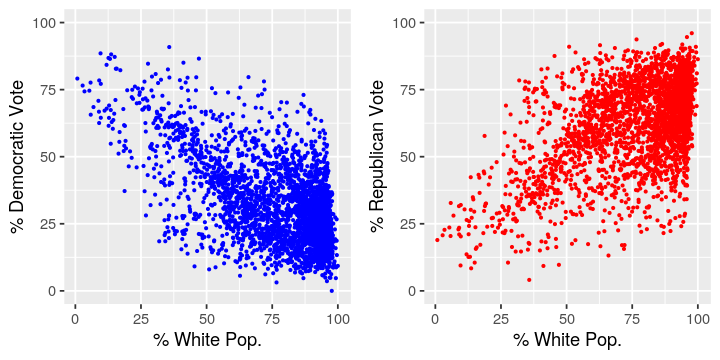

In [8]:
library(ggplot2)
library(cowplot) # This library allows us to use the polot_grid() function

options(repr.plot.width=6, repr.plot.height=3) # These are settings for the size of the output plot

p1 <- ggplot(df, aes(x=white_pct, y=dem16_pct)) + geom_point(col=4, size=0.5) + ylim(0,100) + labs(x="% White Pop.",y="% Democratic Vote")
p2 <- ggplot(df, aes(x=white_pct, y=rep16_pct)) + geom_point(col=2, size=0.5) + ylim(0,100) + labs(x="% White Pop.",y="% Republican Vote") 

plot_grid(p1, p2, ncol=2) # This places the two independent plots in grid (2 x 1 in this case)


From these plots we can clearly see that counties with higher percentage of white population also present higher percentage of Republican vote and lower percentage of Democratic vote. Despite the big dispersion of the points, especially on the 75%-100% band, we can somewhat see a straight line on both plots. This is a first piece of evidence towards the linear relationship. However, we might want it to be less based on the eyesight and more number based. In that case a good candidate test to perform here is the Pearson linear correlation, which in R can be run by using the `cor.test()` function and specifying the parameter `method="pearson"`. Note that by changing the parameter method we can also perform [other type of correlation tests](https://www.rdocumentation.org/packages/stats/versions/3.6.2/topics/cor.test).

In [9]:
corr_dem_white <- cor.test(df$dem16_pct,df$white_pct, method="pearson") # Correlation % democrats - % white
print(corr_dem_white)

corr_rep_white <- cor.test(df$rep16_pct,df$white_pct, method="pearson") # Correlation % republican - % white
print(corr_rep_white)


	Pearson's product-moment correlation

data:  df$dem16_pct and df$white_pct
t = -40.498, df = 3109, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.6102025 -0.5641710
sample estimates:
       cor 
-0.5876621 


	Pearson's product-moment correlation

data:  df$rep16_pct and df$white_pct
t = 35.08, df = 3109, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.5068654 0.5572361
sample estimates:
      cor 
0.5325221 



From the console print outs, we can see relatively strong values for the correlation in both cases Democratic (-0.5876621) and Republican (0.5325221). The negative sign for the democratic case indicates *anti-correlation*, the more % white the less % vote.

So far we have only considered one single demographic indicator, if we want to systematically check  can systematically analyse the 

<div class="alert alert-block alert-info"><b>Exercise 1:</b><br> Create a piece of code that iterates over all demographic indicators, computes the Pearson correlation coefficient between each of them and the percentage vote for Democratic and Republican parties, and stores all values into a new data frame. Then, find out which is the demographic indicator with a higher value of the correlation (positive or negative) for both Democratic and Republican percentage vote.<br><br><i>Hint: If you store the output of the cor.test() into a variable, you can check how to access the different elements with str().</i> </div>

## Performing the Linear Regression
---

We have now compiled good evidence about the linear relationship between some demographic indicators and the vote percentage for both Republican and Democratic parties at county level. The next step is to actually perform the linear regression. This can be easily achieved in R by using the `lm()` command (see the documentation [here](https://www.rdocumentation.org/packages/stats/versions/3.6.2/topics/lm)). The first, and most important, argument of the function is the `formula`, where we need to specify the independent variable (let's call it Y) and the dependent variable (let's call it X) in the following way: `Y~X`. X and Y can directly be two different vectors of the same size, or column names in a data frame - in which case we'll need to provide the data frame in the `data` argument. Note that, unlike in the correlation test, here the order is important. Thus, function will try to fit the parameters of the below linear model:

$Y=AX + B + \epsilon$

This means that R will provide the values of A (slope) and B (intercept) that better adjust to the cloud of points. The distance from each point to the model is called error or _residual_ and corresponds to the $\epsilon$ in the above equation. Thus, if we consider Y the percentage of Republican vote in one county, the value of Y can be calculated as the value of the percentage of white population times X, plus B, plus the error. 

Let's see how this plays out in practice.


In [11]:
linearModelRepWhite <- lm(rep16_pct ~ white_pct, data=df)
summary(linearModelRepWhite)


Call:
lm(formula = rep16_pct ~ white_pct, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-46.130  -8.034   1.198   9.087  38.896 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 30.51744    0.96313   31.69   <2e-16 ***
white_pct    0.42317    0.01206   35.08   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 13.28 on 3109 degrees of freedom
Multiple R-squared:  0.2836,	Adjusted R-squared:  0.2833 
F-statistic:  1231 on 1 and 3109 DF,  p-value: < 2.2e-16


After the linear model is performed, the `summary()` command provides a console printed text with very useful information. In this case, the linear regression provides values of $A=0.4231 \pm 0.01206$ and $B=30.51744 \pm 0.96313$. The means that for each percentage point the counties increase in white population, the percentage vote to Republicans increases by 0.42. The text also contains some other useful information such as the distribution of the residuals $\epsilon$ or the values for $R^2$ (0.2833 in this case) that tells us how good is the fit.

Like in the correlation test, we can also access the different elements of the output by using the `$` This is particularly useful for storing the results into variables.

In [12]:
A <- as.numeric(linearModelRepWhite$coefficients[2])
paste0("A = ", round(A,2))

B <- as.numeric(linearModelRepWhite$coefficients[1])
paste0("B = ", round(B,2))

R2 <- summary(linearModelRepWhite)$adj.r.squared
paste0("R2 = ", round(R2,2))

[1] "A = 0.42"

[1] "B = 30.52"

[1] "R2 = 0.28"

We can also use the results stored in the `linearModelRepWhite` to plot the linear regression overlapping the scatter plot.

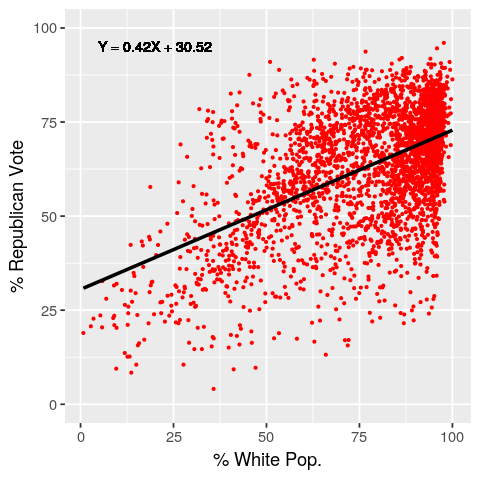

In [13]:
# Generate the text for the equation
eq_text = paste0("Y = ",round(A,2),"X + ",round(B,2))

options(repr.plot.width=4, repr.plot.height=4) # These are settings for the size of the output plot

ggplot(df, aes(x=white_pct, y=rep16_pct)) + 
  geom_point(col=2, size=0.5) + ylim(0,100) + labs(x="% White Pop.",y="% Republican Vote") + 
  geom_smooth(method = "lm", se=FALSE, color="black", formula = y ~ x) +
  geom_text(x = 20, y = 95, label = eq_text, size=3)

<div class="alert alert-block alert-info"><b>Exercise 2:</b><br> In a similar way that in the previous exercise, write a piece of code that that iterates over all demographic indicators and perform a simple linear regression for each of them and both the percentage vote for Democratic and Republican parties. Then store the values for the intercept in a new data frame. Find out which is the demographic indicator with a higher slope for both parties vote and plot the corresponding scatter plot with the regression line and equation.</div>

## Analysing the Residuals
---

Now we know how to perform the simple linear regression in R. However, this is not the end of the road. After trying one model we need to critically assess how good is our model, or even whether the model selected is adequate.

Let's consider for a moment that our model is correct. The first question we might get from anyone who has seen the plot of our linear regression can be something like: _"OK, I can see that the points more or less tend to align to the straight line you just draw, but it's clearly not perfect, good is your model?"_ This takes us to the [regression validation](https://en.wikipedia.org/wiki/Regression_validation) and the importance of [residual analysis](https://www.youtube.com/watch?v=iMdtTCX2Q70).

Indeed, the residuals can tell us a lot. For example, if we just want to provide an overall accuracy of our model we can compute measures such as the [mean absolute error (MAE)](https://en.wikipedia.org/wiki/Mean_absolute_error). We can make those calculations after having stored the output of a `lm()` into a variable by simply accessing the vector with all the residuals using `$residuals`. For example, in the case of the % Republican vote - % White population: 

In [15]:
#Computing the MAE for % Republican Vote - % White Pop.
MAE <- mean(abs(linearModelRepWhite$residuals))
paste0("MAE Republican-White = ", round(MAE,2), "%")

[1] "MAE Republican-White = 10.43%"

This basically means that if we try to use our model to predict the percentage of Republican vote in each county based only on the percentage of white population living in that county we will make an error of a 10% on average in our estimations. This quite a lot, and it is also assuming that our model is appropriate. But is our model appropriate? It is true that before running our linear regression we have compiled some evidence on the possible linear relationship in our two variables. But the real validation of the regression is done by looking at the residuals, and in particular at the residuals plot.

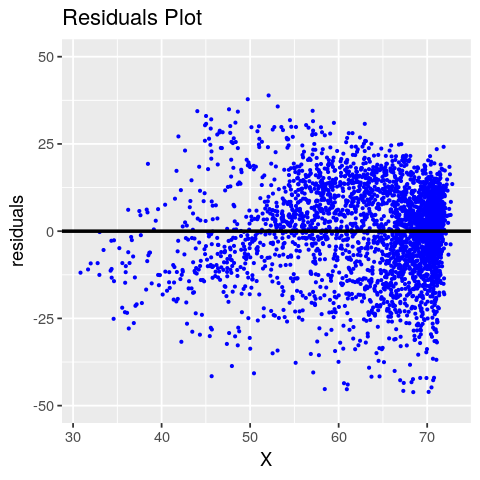

In [16]:
# Get the values from X and residuals from the linear model output
residuals <- linearModelRepWhite$residuals
X <- linearModelRepWhite$fitted.values
# Create a data frame with the values
dfres <- data.frame(X,residuals)

options(repr.plot.width=4, repr.plot.height=4) # These are settings for the size of the output plot
ggplot(dfres, aes(x=X, y=residuals)) + geom_point(col=4, size=0.5) + geom_hline(yintercept=0, lwd=1) + ylim(-50,50) + labs(title="Residuals Plot")

As we see in the plot above the residuals tend to be negative (overestimating) at the beginning and positive (underestimating) towards the end. Additionally, the dispersion of the residuals along the X seems to be not constant - the band from 40 to 60 shows a higher dispersion than the rest. We also see some odd patterns, such as this positive trend that bends towards the end. This clearly differs from the ideal case where all points should concentrate along the 0 with some constant dispersion and showing no patterns.

After all the $\epsilon$ in the [equation above](#Performing-the-Linear-Regression) is meant to be normally distributed and in this particular case it doesn't look so. It is true that someone could find the analysis of the residuals plot a bit subjective. Fortunately, there are other ways much more quantitative to address this, for example performing a normality test. The [Shapiro-Wilk test](https://en.wikipedia.org/wiki/Shapiro%E2%80%93Wilk_test) is able to determine the likelihood that a specific set of values might come from a normal distribution. R makes very easy to run this test thanks to the function `shapiro.test()`, which takes as an argument the vector of values we want to test.

In [17]:
# Shapiro-Wilk normality test for the residuals of linearModelRepWhite
shapiro.test(linearModelRepWhite$residuals)


	Shapiro-Wilk normality test

data:  linearModelRepWhite$residuals
W = 0.98873, p-value = 5.225e-15


This console output is showing a very low p-value - we usually consider low values anything under 0.05. This is telling us that the likelihood that the distribution of the residuals is coming from a normal distribution is extremely low, therefore our residuals cannot be considered normally distributed. This means that our simple regression based on the white percentage of county's population is enough to describe accurately the county's republican vote percentage. It looks like our model is too simple and should consider more variables.

Now, you've got an idea why psephology can be a complicated science after all.

<div class="alert alert-block alert-info"><b>Exercise 3:</b><br> Check which are, if any, the demographic indicators that can be used reliably -where residuals are normally distributed- to describe the percentage of vote for any two parties using a simple linear regression. Compute as well the Mean Absolute Error for each case. </div>

---
<div style="text-align: right ;font-size: small; color: gray"> Notebook by <a href="http://mariogutierrezroig.net">Mario Gutiérrez-Roig</a>, Lecturer in Data Science and Statistics at the University of Essex <a href="http://creativecommons.org/licenses/by-sa/4.0/" rel="license"><img src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" alt="Licencia de Creative Commons" hspace="10" align="right"></a></div>